# Fast Feedback Indexer

(hans-christian.stadler@psi.ch)

At the SLS (Swiss Light Source) operated by PSI (Paul Scherrer Institute), scientists work with coherent monochromatic X-rays to find out more about proteins in frozen state - protein crystals. Such insights are useful for biological and drug research, e.g. to find the structure of viruses like SARS-CoV-2. This is one of the bread and butter activities at synchrotron facilities all over the world.

PSI is in the final stages of upgrading SLS to a higher luminance. More light means, similar to ordinary photocameras, smaler exposure times for the photon detectors at SLS - and thus more images and a higher data rate. Modern detectors can shoot 16 megapixel images with 1kHz, potentially resulting in terrabytes of data per day. This is a bit too much for the PSI budget and the IT systems that need to store and analyse data.

However, much data is bad, like when a protein crystall is not pure, when there is no crystall at all, or when there are ice crystalls in the path of the light. One way of saving data storage capacity is to throw bad data away. Therefore fast feedback analysis is needed to detect bad data.

![Intro serial crystallography](img/intro_serial_toro.png)

## Project

Scientists (Filip Leonarski) had a solution, where a so called indexing algorithm, implemented in C++ with a state of the art matrix algebra library, took the most time per image - about 80ms on one CPU core of a relevant system. They wanted indexing to be done in preferably less than 1ms, possibly on a GPU. Since the basic crystal structure is usually known (protein components are often known, otherwise it can be found during experiment setup), it was allowed to take this as a given.

## First steps

Measure performance of the existing algorithm. On one core of an Intel i7-10875H laptop the likwid-perfctr results were ok.

| Metric                            | Result       |
| --------------------------------- | ------------ |
|                CPI                |       0.3988 |
|            SP [MFLOP/s]           |    5798.4982 |
|          AVX SP [MFLOP/s]         | 6.415714e-08 |
|          Packed [MUOPS/s]         |    1418.2049 |
|          Scalar [MUOPS/s]         |     125.6785 |
|  Memory load bandwidth [MBytes/s] |      87.3364 |
|  Memory load data volume [GBytes] |      10.8903 |
| Memory evict bandwidth [MBytes/s] |      56.0482 |
| Memory evict data volume [GBytes] |       6.9889 |
|    Memory bandwidth [MBytes/s]    |     143.3845 |
|    Memory data volume [GBytes]    |      17.8792 |
|       Operational intensity       |      40.4402 |
|        Vectorization ratio        |      91.8596 |

Especially the vectorization ratio is excellent, and the stellar CPI (clocks per instruction) can only be explained with that. Operational intensity of 40 FLOPS/byte is also ok.

So the existing sequential algorithm was quite performant, and it was the fastest known at that time according to the scientists. To get a factor of 1/80 in runtime, it was decided to devise a new algorithm, taking advantage of GPU and known crystal structure.

## Results

We managed to get throughput below 1ms on a single modern GPU (Ampere generation), with 3 to 4 operations in flight. The code is [here](https://github.com/paulscherrerinstitute/fast-feedback-indexer) and has been integrated in the two major softare packages for crystallography, [Dials](https://dials.github.io) and [CrystFEL](https://www.desy.de/~twhite/crystfel). When using our indexer, indexing is no longer the slowest part in these pipelines.

Filip Leonarskis Jungfraujoch crystallography pipeline for online analysis of modern Jungfrau detector images integrates the fast feedback indexer. With his pipeline, it's possible for the first time to throw bad data away in a reliable fashion.

## Laue diffraction and Bragg's law

Let's look at [Wikipedia - Bragg's law](https://en.wikipedia.org/wiki/Bragg%27s_law). The fast feedback indexing problem is to find the orientation of a known crystal unit cell. For this, spots are mapped onto a 3D half sphere, the Ewald sphere. Unit cell vectors should form an integer dot product with good spots.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Read reciprocal spots from a simple file (first 9 numbers are unit cell vectors)
with open('image0_local.txt', 'r', encoding="utf-8") as data:
    spots = np.array([float(s) for s in data.read().split()][9:]).reshape((-1,3))
print(spots.shape)

(297, 3)


Text(0.5, 0.92, 'Spots on Ewald Sphere')

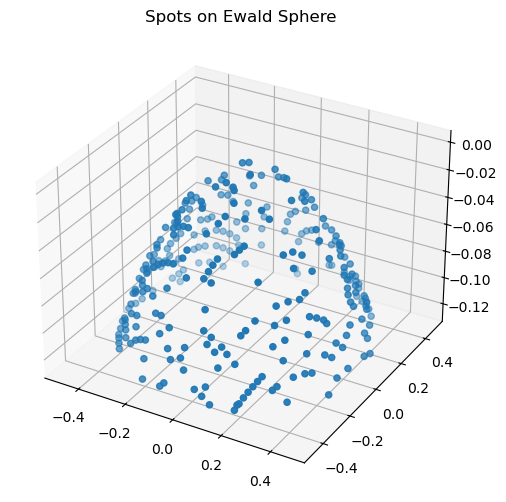

In [9]:
# Scatter plot of reciprocal spots
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(spots[:,0], spots[:,1], spots[:,2])
plt.title('Spots on Ewald Sphere')

The task is now to reorient a given cell (3 vectors representing the crystal structure) such that a significant subset of these reciprocal spots (seen as vectors from the origin to the spot) have an integer dot product with everyone of these 3 cell vectors.

## Algorithm step one

The first step (kernel) is to do a brute force sampling for the direction of the given unit cell vectors (all fast algorithms do that), calculating a quality score (simplest: number of spots with which the vector forms an integer dot product, up to an error threshold).

As the calculations for every direction is independent, and there are around 32000 of them, this is well suited for the GPU.

<img src="img/spots_on_sphere.png" width="500"/>
<!--
![Sampling points](img/spots_on_sphere.png)
-->

The best (say 32) scoring directions are then collected.

* Sorting within blocks, the 32 first threads write their direction and score to shared memory.
* First thread in block aquires a spin lock.
* First thread in block merges the result in shared memory into the result in global memory.
* First thread in block releases the spin lock.

This is not ideal, as sorting is too much work, and then only few or one thread in the block are doing some work.

## Algorithm step two

The second step (kernel) picks up results from the previous kernel and refines the best vectors by repeatedly adapting them a fixed number of times

1. Calculate the integer dot product per spot by rounding the dot product.
2. Select spots with dot procuts deviating less than a threshold.
3. Adapt vector to selected spots and their integer dot product using least squares.
4. Decrease the threshold and repeat from 2

Write the result to global memory.

Even though the calculations are independent for every one of the best found vectors, there are too few of them. This is not a good GPU workload. But shipping data to the CPU and back to the GPU again was worse.

## Algorithm step three

The third step (kernel) picks up the adapted best candidate vectors, attaches the other two vectors according to the known crystal structure, and does a brute force sampling of the rotation around the candidate vector, calculating a score that combines the scores for the three cell vectors (simplest: number of spots with limited euclidean distance of dot products to rounded dot products).

As the calculations for every rotation angle are independent, this is well suited for a GPU.

<img src="img/sample_angles.png" width="500"/>
<!--
![Sample angles](img/sample_angles.png)
-->

The best (say 32) scoring (candidate vector, angle) pairs are then collected in a way similar to step one, using block wide sorting, spin lock and merging from shared to global memory. This not ideal, as before.

## Algorithm step four

The fourth step (kernel) assembles the best candidate unit cells from (candidate vector, angle) pairs.

Even though the calculatioins for every candidate unit cell are independent, there are too few of them to make a good GPU workload. But this makes candidate unit cell assembly consistent.

## Algorithm step five

The same refinement as in step two is done one the CPU, because the workload is not well suited for the GPU, and it is the last step.

## Conclusion

It looks like more speed is possible.